In [2]:
import keras
from keras.preprocessing import sequence
from keras.layers import Dense,LSTM, Dropout
import tensorflow as tf
import os
import numpy as np
import pandas as pd 
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [3]:
from google.colab import files
import io
uploaded = files.upload()
train_data = pd.read_csv(io.BytesIO(uploaded['Google_Stock_Price_Train.csv']))
uploaded = files.upload()
test_data = pd.read_csv(io.BytesIO(uploaded['Google_Stock_Price_Test.csv']))
#dataset = pd.read_csv('Google_Stock_Price_Train.csv',index_col="Date",parse_dates=True)

Saving Google_Stock_Price_Train.csv to Google_Stock_Price_Train.csv


Saving Google_Stock_Price_Test.csv to Google_Stock_Price_Test.csv


In [4]:
print(train_data["Close"].values)

['663.59' '666.45' '657.21' ... '785.05' '782.79' '771.82']


In [5]:
data=pd.to_numeric(train_data.Close,errors='coerce')
len(data)

1258

1. pass closing values in to process data which 
  - finds the difference between the closing price of each day
  - creates the sequence of train and test data and the scaler
2. extract the x and y  values from the train and test data 
3. Pass the x and y in to the fit model function

In [6]:
#find Difference of the close series
def difference(data,interval=1):
  diff = list()
  for i in range(interval,len(data)):
    value=data[i]-data[i-interval]
    diff.append(value)
  return pd.Series(diff)

In [7]:
#create arguments with n_in as previous observations and n_out as the result
def createSequence(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [8]:
#example
a=difference([1,3,3,4,5,6,7])
print(a.values)

[2 0 1 1 1 1]


In [9]:
# Scales the data and splits data in to training and testing
def process_data(series, n_test, n_lag, n_out):
	# extract raw values
	raw_values = series.values
	# transform data to be stationary
	diff_series = difference(raw_values, 1)
	diff_values = diff_series.values
	diff_values = diff_values.reshape(len(diff_values), 1)
	print(diff_values)
	# rescale values to -1, 1
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaled_values = scaler.fit_transform(diff_values)
	scaled_values = scaled_values.reshape(len(scaled_values), 1)
	print(scaled_values)
	# transform into supervised learning problem X, y
	supervised = createSequence(scaled_values, n_lag, n_out)
	supervised_values = supervised.values
	# split into train and test sets
	train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
	return scaler, train, test

In [10]:
#example
a=pd.Series([1,2,3,4,5,6,7])
scaler,train,test=process_data(a,2,2,1)

print(train)
print(test)
x_train=(train[:, 0:2])
x_train=np.reshape(x_train,(x_train.shape[0],1,x_train.shape[1]))
y_train=train[:,2:]


#print (x_train)
#print(y_train)


[[1]
 [1]
 [1]
 [1]
 [1]
 [1]]
[[-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]]
[[-1. -1. -1.]
 [-1. -1. -1.]]
[[-1. -1. -1.]
 [-1. -1. -1.]]


In [55]:
#create the LSMT Learning Model
def createModel(rnn_units,n_lag,output_size):
  model=tf.keras.Sequential()
  model.add(LSTM(units = rnn_units, return_sequences = True, input_shape = (n_lag, 1)))
  model.add(Dropout(0.1))
  model.add(LSTM(units = rnn_units))
  model.add(Dropout(0.1))
  model.add(Dense(units = output_size))
  return model

In [56]:
# fit an LSTM network to training data
def fit_lstm(train, n_lag,output_s,batch_s,n_epochs,n_neurons):
	# reshape training into [samples, timesteps, features]
  X, y = train[:, 0:n_lag], train[:, n_lag:]
  X = np.reshape(X,(X.shape[0],X.shape[1],1))
  y= np.reshape(y,(y.shape[0],))
	# design network
  model = createModel(n_neurons,n_lag,output_s)
  model.compile(loss='mean_squared_error', optimizer='adam')
	# fit network
  #model.fit(X, y, epochs=n_epochs, batch_size=batch_s, verbose=2)
  for i in range(n_epochs):
    model.fit(X, y, epochs=1, batch_size=batch_s, verbose=2, shuffle=False)
    model.reset_states()
  return model

In [57]:
N_TEST=100
N_LAG=40
N_OUT=1
BATCH_S=32
EPOCHS=75
RNN_NEURONS=50
scaler, train_data, test_data=process_data(data,N_TEST,N_LAG,N_OUT)

[[  2.86]
 [ -9.24]
 [ -8.97]
 ...
 [ -6.5 ]
 [ -2.26]
 [-10.97]]
[[-0.17627119]
 [-0.33402868]
 [-0.33050847]
 ...
 [-0.29830508]
 [-0.24302477]
 [-0.35658409]]


In [62]:
print(train_data.shape)

(1050, 21)


In [58]:
model=fit_lstm(train_data, N_LAG, N_OUT,BATCH_S, EPOCHS,RNN_NEURONS)

31/31 - 1s - loss: 0.0219
31/31 - 1s - loss: 0.0157
31/31 - 1s - loss: 0.0156
31/31 - 1s - loss: 0.0156
31/31 - 1s - loss: 0.0157
31/31 - 1s - loss: 0.0155
31/31 - 1s - loss: 0.0157
31/31 - 1s - loss: 0.0157
31/31 - 1s - loss: 0.0157
31/31 - 1s - loss: 0.0156
31/31 - 1s - loss: 0.0157
31/31 - 1s - loss: 0.0156
31/31 - 1s - loss: 0.0156
31/31 - 1s - loss: 0.0156
31/31 - 1s - loss: 0.0155
31/31 - 1s - loss: 0.0155
31/31 - 1s - loss: 0.0158
31/31 - 1s - loss: 0.0155
31/31 - 1s - loss: 0.0156
31/31 - 1s - loss: 0.0156
31/31 - 1s - loss: 0.0156
31/31 - 1s - loss: 0.0156
31/31 - 1s - loss: 0.0155
31/31 - 1s - loss: 0.0155
31/31 - 1s - loss: 0.0154
31/31 - 1s - loss: 0.0156
31/31 - 1s - loss: 0.0156
31/31 - 1s - loss: 0.0153
31/31 - 1s - loss: 0.0155
31/31 - 1s - loss: 0.0155
31/31 - 1s - loss: 0.0155
31/31 - 1s - loss: 0.0154
31/31 - 1s - loss: 0.0154
31/31 - 1s - loss: 0.0155
31/31 - 1s - loss: 0.0155
31/31 - 1s - loss: 0.0155
31/31 - 1s - loss: 0.0154
31/31 - 1s - loss: 0.0154
31/31 - 1s -

In [16]:

X_test,real_stock_price = test_data[:, 0:N_LAG], test_data[:, N_LAG:]
#real_stock_price=scaler.inverse_transform(real_stock_price)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
predicted_stock_price = model.predict(X_test)

predicted_stock_price = scaler.inverse_transform(predicted_stock_price)
predicted_stock_price = pd.DataFrame(predicted_stock_price)

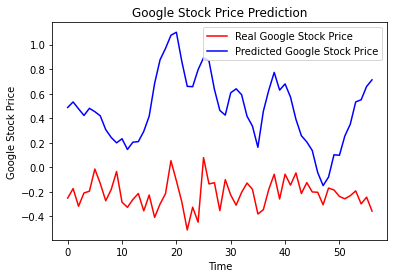

In [17]:

# Visualising the results
plt.plot(real_stock_price, color = 'red', label = 'Real Google Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

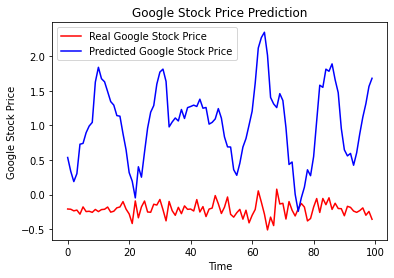

In [59]:
X_test,real_stock_price = test_data[:, 0:N_LAG], test_data[:, N_LAG:]
#real_stock_price=scaler.inverse_transform(real_stock_price)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
predicted_stock_price = model.predict(X_test)

predicted_stock_price = scaler.inverse_transform(predicted_stock_price)
predicted_stock_price = pd.DataFrame(predicted_stock_price)

# Visualising the results
plt.plot(real_stock_price, color = 'red', label = 'Real Google Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

In [36]:
print(predicted_stock_price)
print(real_stock_price)

           0
0   1.241239
1   1.212550
2   1.110825
3   0.766969
4   0.810804
5   0.903159
6   0.982217
7   0.858133
8   0.450431
9   0.371414
10  0.575313
11  0.219860
12  0.054242
13  0.209423
14  0.420255
15  0.583631
16  0.882059
17  0.994835
18  1.327447
19  1.745251
20  1.970568
21  1.993310
22  1.609303
23  1.028750
24  0.894491
25  0.763623
26  1.049793
27  1.125201
28  1.200540
29  0.840141
30  0.663592
31  0.593078
32  0.496566
33  0.570065
34  0.692078
35  0.837992
36  0.608794
37  0.722237
38  1.049231
39  1.327425
40  1.005236
41  1.013314
42  0.988382
43  1.111646
44  0.864652
45  0.828026
46  0.226880
47 -0.005692
48 -0.253850
49  0.055900
50  0.149978
51  0.338251
52  0.604364
53  0.823162
54  0.994869
55  1.065392
56  1.384728
[[-0.25097784]
 [-0.17353325]
 [-0.31720991]
 [-0.20912647]
 [-0.19491525]
 [-0.01408083]
 [-0.13220339]
 [-0.2726206 ]
 [-0.18226858]
 [-0.03441982]
 [-0.28448501]
 [-0.32568449]
 [-0.26205997]
 [-0.21329857]
 [-0.3547588 ]
 [-0.22568449]
 [-0.4